## AutoEncoder: Comparative Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision

import sys, os

sys.path.append(os.path.abspath("../../performance-measures"))
sys.path.append(os.path.abspath("../../models/AutoEncoders"))
sys.path.append(os.path.abspath("../../models/knn"))

from evaluation import model_evaluation
from AutoEncoders import AutoEncoder
from knn import kNNClassifier

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

### 4.2 CNN AutoEncoder

#### 4.2.1 Dataset Analysis and Preprocessing

In [2]:
def Normalize(X, mean, std_dev):
    X = X.astype(np.float64)
    X = X/255.0
    X = X.reshape(-1, 1, 28, 28)
    return X


train_val_path = '../../data/external/fashion_mnist/fashion-mnist_train.csv'  
test_path = '../../data/external/fashion_mnist/fashion-mnist_test.csv'  
df_train_val = pd.read_csv(train_val_path)
df_test = pd.read_csv(test_path)

Y_train_val = df_train_val.iloc[:, 0].values  
X_train_val = df_train_val.iloc[:, 1:].values 
mean = np.mean(X_train_val) 
std_dev = np.std(X_train_val)
X_train_val = Normalize(X_train_val, mean, std_dev)

Y_test = df_test.iloc[:, 0].values  
X_test = df_test.iloc[:, 1:].values 
X_test = Normalize(X_test, mean, std_dev)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=1/6, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(Y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

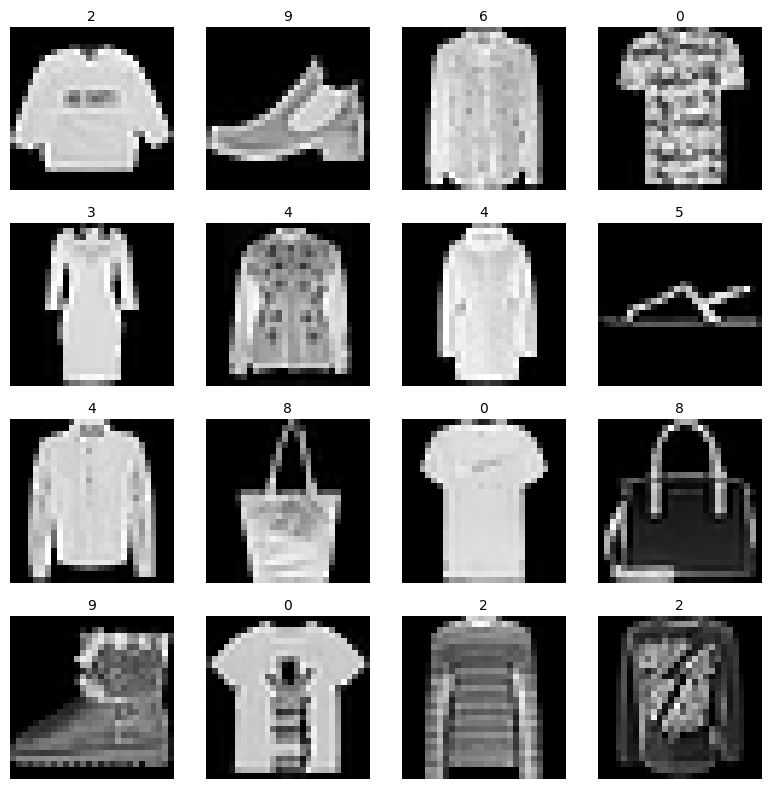

In [3]:

def show_images(images, labels):
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axs.flat):
        img = images[i].squeeze().numpy()  
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'{int(labels[i])}', fontsize=10, pad=5, color='black')
    
    plt.tight_layout()
    plt.show()

labels = df_train_val.iloc[:, 0].values  
images = df_train_val.iloc[:, 1:].values 
images = images.reshape(-1, 1, 28, 28)
images = torch.tensor(images, dtype=torch.float32)

show_images(images[:16], labels[:16])



This dataset represents different types of clothing items
- class-0  represents t-shirts
- class-2  represents jackets
- class-3  represents shirts
- class-4  represents t-shirts/trouser
- class-5  represents sandals
- class-6  represents shirts
- class-8  represents bags
- class-9  represents shoes

#### 4.2.2 CnnAutoencoder class

In [4]:
class CnnAutoencoder(nn.Module):
    def __init__(self,
                 learning_rate=0.001,
                 num_epochs=20,
                 optimizer='adam',
                 reduced_dim=128,
                 ):
        super(CnnAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, reduced_dim, kernel_size=7), 
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(reduced_dim, 64, kernel_size=7),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid() 
        )
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.loss_function = nn.MSELoss()
        self.init_optimizer(optimizer=optimizer)

        self.train_losses=[]
        self.val_losses=[]

    def init_optimizer(self, optimizer):
        if optimizer == 'adam':
            self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        elif optimizer == 'sgd':
            self.optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)
        elif optimizer == 'rmsprop':
            self.optimizer = optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif optimizer == 'adagrad':
            self.optimizer = optim.Adagrad(self.parameters(), lr=self.learning_rate)
        elif optimizer == 'adadelta':
            self.optimizer = optim.Adadelta(self.parameters(), lr=self.learning_rate)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        latent_space = self.encode(x)  
        reconstructed = self.decode(latent_space)  
        return reconstructed

    def train_model(self, train_loader, val_loader, device):
        self.to(device) 
        self.train()
        self.train_losses=[]
        self.val_losses=[]

        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for data in train_loader:
                img, _ = data 
                img = img.to(device)

                output = self.forward(img)
                loss = self.loss_function(output, img) 

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            train_loss = running_loss / len(train_loader)
            val_loss = self.evaluate(val_loader, device)
            print(f'Epoch [{epoch+1}/{self.num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

    def evaluate(self, val_loader, device):
        self.to(device)
        self.eval()  
        running_loss = 0.0

        with torch.no_grad(): 
            for data in val_loader:
                images, _ = data
                images = images.to(device)

                output = self.forward(images)
                loss = self.loss_function(output, images)
                running_loss += loss.item()

        loss = running_loss / len(val_loader)
        return loss

In [5]:
cnn_autoencoder = CnnAutoencoder(learning_rate=0.001,
                             optimizer='adam',
                             num_epochs=10,
                             )

cnn_autoencoder.train_model(train_loader, val_loader, device=device)

test_loss = cnn_autoencoder.evaluate(test_loader, device)
print(f'Test Loss : {test_loss:.4f}')

Epoch [1/10], Train Loss: 0.0237, Val Loss: 0.0114
Epoch [2/10], Train Loss: 0.0094, Val Loss: 0.0081
Epoch [3/10], Train Loss: 0.0073, Val Loss: 0.0066
Epoch [4/10], Train Loss: 0.0061, Val Loss: 0.0058
Epoch [5/10], Train Loss: 0.0054, Val Loss: 0.0053
Epoch [6/10], Train Loss: 0.0049, Val Loss: 0.0049
Epoch [7/10], Train Loss: 0.0045, Val Loss: 0.0045
Epoch [8/10], Train Loss: 0.0042, Val Loss: 0.0043
Epoch [9/10], Train Loss: 0.0040, Val Loss: 0.0041
Epoch [10/10], Train Loss: 0.0038, Val Loss: 0.0040
Test Loss : 0.0040


#### 4.2.3 Plots and Visualizations

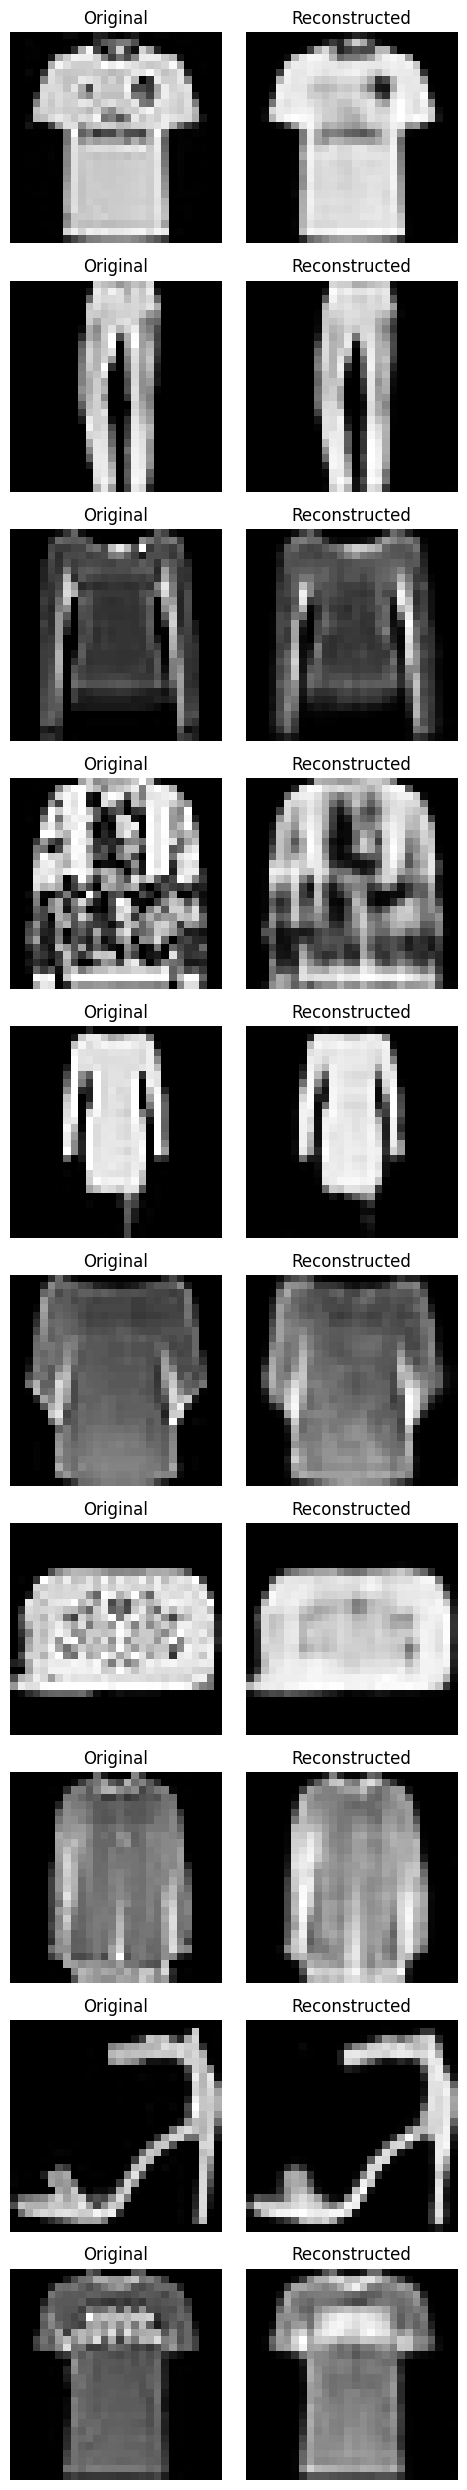

In [6]:
def plot_reconstructed_images(images, reconstructed_images, outpath, num_images):
    fig, axes = plt.subplots(num_images, 2, figsize=(5, 2.5 * num_images))
    images = images * 255
    reconstructed_images = reconstructed_images * 255

    for i in range(num_images):
        axes[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Original")

        axes[i, 1].imshow(reconstructed_images[i].squeeze(), cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title("Reconstructed")

    plt.tight_layout()
    plt.savefig(outpath)
    plt.show()
  
num_images=10
images,_ = next(iter(test_loader))
images = images[:num_images].to(device)
reconstructed_images = cnn_autoencoder.forward(images)
images = images.cpu().numpy()
reconstructed_images = reconstructed_images.cpu().detach().numpy()
plot_reconstructed_images(images, reconstructed_images,'figures/cnn_autoencoder_org_vs_reconstructed.png', num_images)


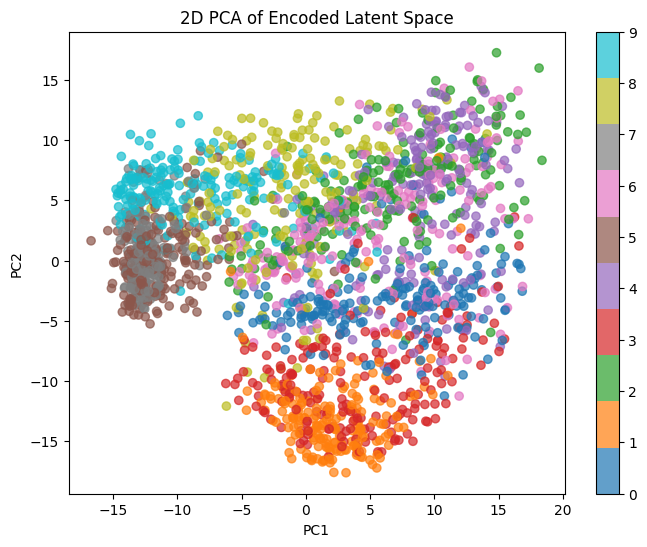

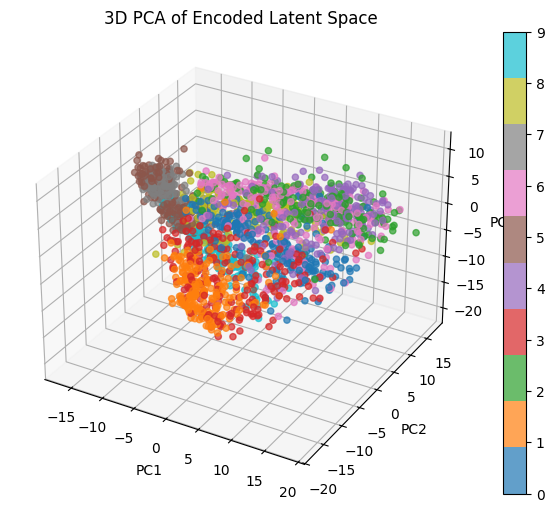

In [7]:
from sklearn.decomposition import PCA

def plot_latent_space(autoencoder, test_loader, device, num_samples=2000, n_components=2):
    autoencoder.eval() 
    all_encoded = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            encoded = autoencoder.encode(images) 
            all_encoded.append(encoded.cpu().numpy())
            all_labels.append(labels.numpy())
            if len(all_encoded) * len(images) >= num_samples:
                break
    
    all_encoded = np.concatenate(all_encoded, axis=0)[:num_samples]
    all_labels = np.concatenate(all_labels, axis=0)[:num_samples]

    pca = PCA(n_components=n_components)
    all_encoded = all_encoded.reshape(-1, 128)
    reduced_encoded = pca.fit_transform(all_encoded)
    
    if n_components == 2:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(reduced_encoded[:, 0], reduced_encoded[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter)
        plt.title('2D PCA of Encoded Latent Space')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.savefig('figures/4_2_3_encoded_repr_2d.png')
        plt.show()
    
    elif n_components == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(reduced_encoded[:, 0], reduced_encoded[:, 1], reduced_encoded[:, 2], c=all_labels, cmap='tab10', alpha=0.7)
        fig.colorbar(scatter)
        ax.set_title('3D PCA of Encoded Latent Space')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        plt.savefig('figures/4_2_3_encoded_repr_3d.png')
        plt.show()

plot_latent_space(cnn_autoencoder, test_loader, device, n_components=2)
plot_latent_space(cnn_autoencoder, test_loader, device, n_components=3)


From the above PCA plots in 2D and 3D we can see the groups in different colors.Items with same classes are forming a cluster

In [8]:
def plot_losses(train_losses, val_losses, title, out_path):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label=f'Train Loss')
    plt.plot(epochs, val_losses, label=f'Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(out_path)
    plt.show()

#### 4.2.4 Hyperparameter Tuning

**Effect of Hyperparameters:**

I tried different combination of hyperparamters some of them are tabulated in the following table:

| S.No.|  Covolution Layers  | Kernel size | optimizer | learning rate | epochs | Test Loss(MSE) |
|------|-------------------|--------------------|------------|-------------|--------|---------------|
|  1   |  [16,32,64,32,16] | [3,3,7,3,3]   |   adam    |    0.001     |   10    |  0.0063    |
|  2   |  [32,64,128,64,32] | [3,3,7,3,3]   |   sgd    |    0.001     |   10    |  0.1240     |
|  3   |  [32,64,128,64,32] | [3,3,7,3,3]   |   rmsprop    |    0.001  |   10    |  0.0119  |
|  4   |  [32,64,128,64,32] | [3,3,7,3,3]   |   adam    |    0.001     |   10    |  0.0059    |
|  5   |  [32,64,128,64,32] | [5,5,7,5,5]   |   adam    |    0.001     |   10    |  0.0067     |

Following are the MSE Loss v/s epochs plots for these combinations

<img src="figures/autoencoder_comb1_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/autoencoder_comb2_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/autoencoder_comb3_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/autoencoder_comb4_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/autoencoder_comb5_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>

**Effect of Number of Layers:**

I tried following combination of layers on this model

| S.No.|  Layer Configuration  | Test Loss(MSE) |
|------|-------------------|--------------------
|  1   |  [16,32,64,128,64,32,16] |  0.0061   |  
|  2   |  [32,64,128,64,32] |  0.0059   |   
|  3   |  [64,128,64] |  0.0079  |  

Following are the MSE Loss v/s epochs plots for these combinations

<img src="figures/autoencoder_layer_config1_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/autoencoder_comb4_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/autoencoder_layer_config3_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>


- We can see that model with less number of layers(combination-3) is has higher loss as compared to other combinations with same number of epochs.
- Model with high number of layer(combination-1) has higher loss in initial epochs.

### MLP Autoencoder 

In [9]:
mlp_autoencoder = AutoEncoder(input_dim=784, 
                          reduced_dim=128, 
                          encoder_hidden_layers=[800,512],
                          decoder_hidden_layers=[512,800],
                          learning_rate=0.001, 
                          activation_function='relu', 
                          epochs=20, 
                          optimizer='mini-batch-gd',
                          batch_size=256)

X_train = X_train.reshape(-1,784)
Y_train = Y_train.reshape(-1,1)
X_val = X_val.reshape(-1,784)
Y_val = Y_val.reshape(-1,1)
X_test = X_test.reshape(-1,784)
Y_test = Y_test.reshape(-1,1)

mlp_autoencoder.fit(X=X_train, X_val=X_val)
reduced_data = mlp_autoencoder.get_latent(X=X_test)

Epoch 1/20 complete, Train Loss : 0.056879804916865256, Val Loss : 0.05648446949311181
Epoch 2/20 complete, Train Loss : 0.04696693909715817, Val Loss : 0.04655989778150599
Epoch 3/20 complete, Train Loss : 0.04275435870216083, Val Loss : 0.042359223299811295
Epoch 4/20 complete, Train Loss : 0.04020322201135369, Val Loss : 0.03983524351063909
Epoch 5/20 complete, Train Loss : 0.03803485282919233, Val Loss : 0.037695501667362324
Epoch 6/20 complete, Train Loss : 0.03654848688349736, Val Loss : 0.036218969153524606
Epoch 7/20 complete, Train Loss : 0.035538602659002695, Val Loss : 0.035236326729129845
Epoch 8/20 complete, Train Loss : 0.03295210913652791, Val Loss : 0.03268064426234258
Epoch 9/20 complete, Train Loss : 0.03280880991136529, Val Loss : 0.03255857315974385
Epoch 10/20 complete, Train Loss : 0.031237354082194916, Val Loss : 0.031001680182652234
Epoch 11/20 complete, Train Loss : 0.031123376630302287, Val Loss : 0.03090181827846483
Epoch 12/20 complete, Train Loss : 0.030091

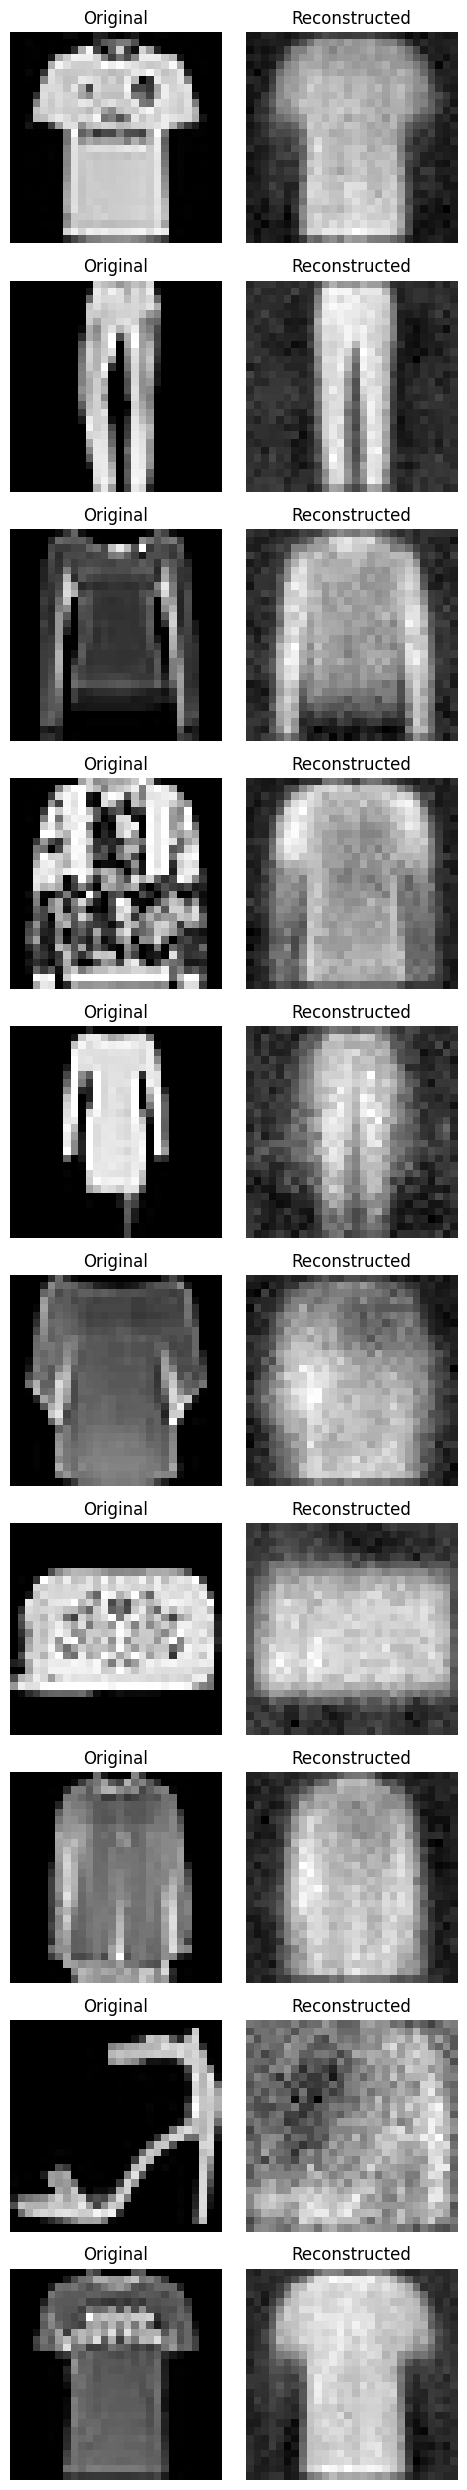

In [10]:
num_images=10
images, _ = next(iter(test_loader))
images = images[:num_images]
flat_images = images.reshape(num_images, 784)

reconstructed_images = mlp_autoencoder.reconstruct(flat_images)
reconstructed_images = reconstructed_images.reshape(-1, 28, 28)
plot_reconstructed_images(images, 
                          reconstructed_images, 
                          'figures/mlp_autoencoder_org_vs_reconstructed.png', num_images)

- By comparing with reconstruted images obtained from CNN autoencoder we can see that CNN autoencoder performs better than MLP autoencoder.
- There is more noise in images reconstruted by MLP autoencoder while the CNN autoencoder outputs better reconstruted images. 

### PCA Autoencoder

#### 4.4.1 PcaAutoencoder Class

In [11]:
class PcaAutoencoder:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.eigenvectors = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        covariance_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[:, sorted_indices]
        self.eigenvectors = eigenvectors[:, :self.n_components]
    
    def encode(self, X):
        X_centered = X - self.mean
        X_encoded = np.dot(X_centered, self.eigenvectors)
        return X_encoded
    
    def forward(self, X):
        X_encoded = self.encode(X)
        X_reconstructed = np.dot(X_encoded, self.eigenvectors.T)
        X_reconstructed += self.mean
        return X_reconstructed

#### 4.4.2 Estimation of Optimal Number of Components

In [12]:
X_train = X_train.reshape(-1,784)
Y_train = Y_train.reshape(-1,1)
X_val = X_val.reshape(-1,784)
Y_val = Y_val.reshape(-1,1)
X_test = X_test.reshape(-1,784)
Y_test = Y_test.reshape(-1,1)

def plot_reconstruction_error_vs_num_components():
    max_components=150
    min_components=1
    reconstruction_errors = []
    components = range(min_components, max_components + 1,1)
    for n_components in components:
        pca_autoencoder = PcaAutoencoder(n_components=n_components)
        pca_autoencoder.fit(X_train)
        X_val_reconstructed = pca_autoencoder.forward(X_val)
        mse_error = np.mean((X_val - X_val_reconstructed)**2)
        reconstruction_errors.append(mse_error)

    plt.figure(figsize=(8, 6))
    plt.plot(components, reconstruction_errors)
    plt.title('Elbow Plot: Reconstruction Error vs. Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.grid(True)
    plt.savefig('figures/pca_elbow_plot.png')
    plt.show()


By analysing the above plot we can see the optimal components close to 128 as it retains 90% of variance with 5% of total reconstruction error  

So **K_optimal** = 128

In [13]:
k_optimal = 128
pca_autoencoder = PcaAutoencoder(n_components=k_optimal)
pca_autoencoder.fit(X_train)
X_encoded = pca_autoencoder.encode(X_train)
X_reconstructed = pca_autoencoder.forward(X_train)

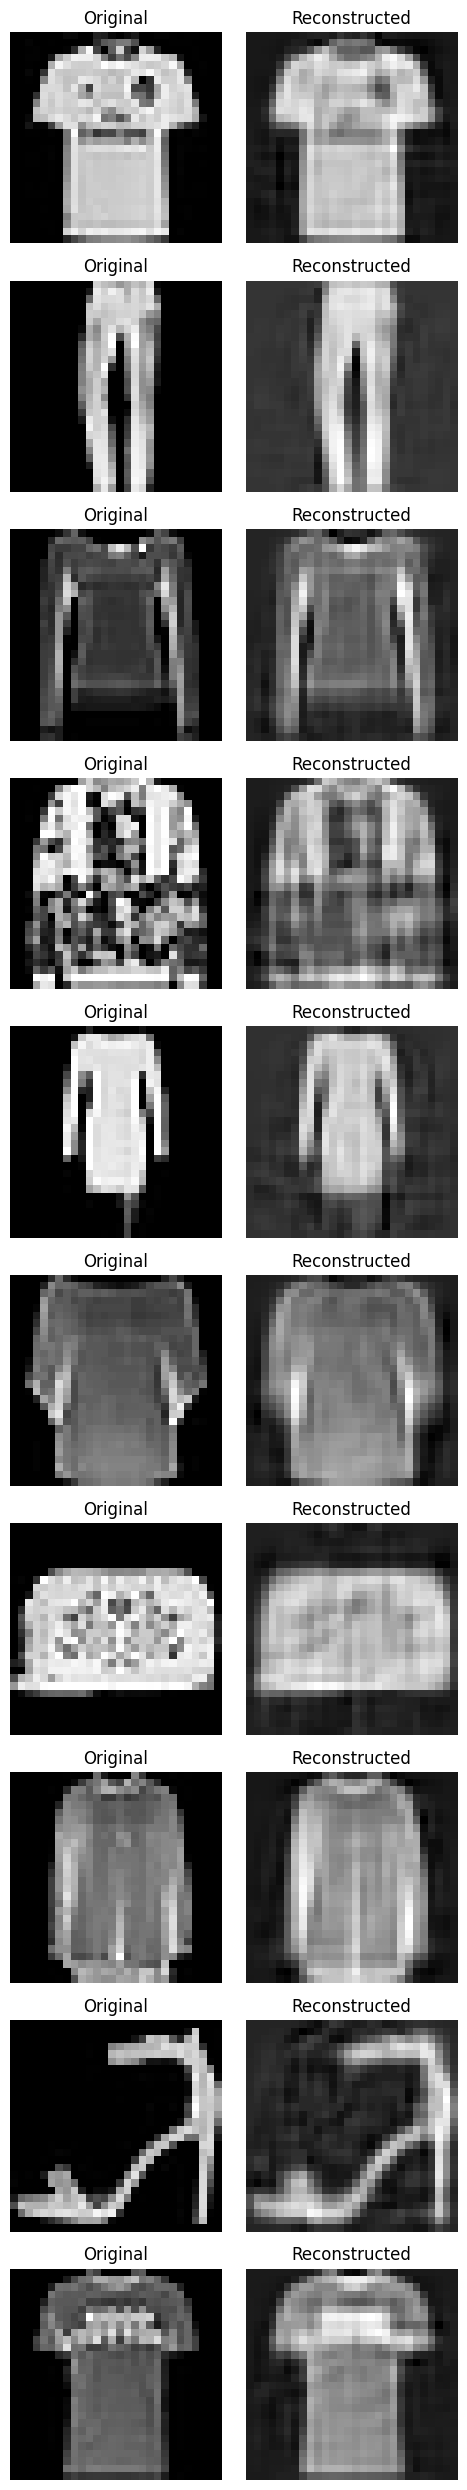

In [14]:
num_images=10
images = X_test[:num_images]
reconstructed_images = pca_autoencoder.forward(images)
images = images.reshape(-1, 28, 28)
reconstructed_images = reconstructed_images.reshape(-1, 28, 28)
plot_reconstructed_images(images, reconstructed_images,'figures/pca_autoencoder_org_vs_reconstructed.png', num_images)

- By comparing above results with CNN autoencoder, the CNN autoencoder performs better that above one. Above results have some noise in background but CNN autencoder outputs better images with very low noise in background.
- By comparing with MLP autoencoder, PCA autoencoder perform a little better.

### KNN Classification

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

latent_train_vectors = []
latent_test_vectors = []

cnn_autoencoder.eval()
with torch.no_grad():
    for data in train_loader:
        images, _ = data  
        images = images.to(device)
        encoded = cnn_autoencoder.encode(images)
        latent_train_vectors.append(encoded.view(encoded.size(0), -1).cpu().numpy()) 

    for data in test_loader:
        images, _ = data  
        images = images.to(device)
        encoded = cnn_autoencoder.encode(images)
        latent_test_vectors.append(encoded.view(encoded.size(0), -1).cpu().numpy())

X_test_reduced_cnn = np.concatenate(latent_test_vectors)
X_train_reduced_cnn = np.concatenate(latent_train_vectors)

print("CNN Autoencoder Done!")

X_train_reduced_mlp = mlp_autoencoder.get_latent(X=X_train)
X_test_reduced_mlp = mlp_autoencoder.get_latent(X=X_test)
print("MLP Autoencoder Done!")

X_train_reduced_pca = pca_autoencoder.encode(X=X_train)
X_test_reduced_pca = pca_autoencoder.encode(X=X_test)
print("PCA Autoencoder Done!")


CNN Autoencoder Done!
MLP Autoencoder Done!
PCA Autoencoder Done!


In [16]:
def predict_in_chunks(knn, X_data, chunk_size=1000):
    predictions = []
    for i in range(0, X_data.shape[0], chunk_size):
        X_chunk = X_data[i:i + chunk_size]
        y_pred_chunk = knn.predict(X_chunk)
        predictions.extend(y_pred_chunk)
    return np.array(predictions)

Y_train = Y_train.squeeze()
Y_test = Y_test.squeeze()

k_best = 11
best_dist_metric = 'cosine'
classes_list = range(0,10)
knn = kNNClassifier(k=k_best, distance_method=best_dist_metric)

In [17]:
print('KNN On Data Reduced by CNN Autoencoder')

knn.fit(X_train_reduced_cnn, Y_train)
y_pred_train = predict_in_chunks(knn, X_train_reduced_cnn, chunk_size=1000)
y_pred_test = predict_in_chunks(knn, X_test_reduced_cnn, chunk_size=1000)

evaluation = model_evaluation(y_true=Y_train, y_pred=y_pred_train, classes_list=classes_list)
print(f'Train Accuracy : {evaluation.accuracy_score()}')
cnn_train_accuracy = evaluation.accuracy_score()
evaluation = model_evaluation(y_true=Y_test, y_pred=y_pred_test, classes_list=classes_list)
print(f'Test Accuracy : {evaluation.accuracy_score()}')
cnn_test_accuracy = evaluation.accuracy_score()
cnn_confusion_matrix = evaluation.calculate_confusion_matrix()

print("")

KNN On Data Reduced by CNN Autoencoder
Train Accuracy : 0.90544
Test Accuracy : 0.884



In [18]:
print('KNN On Data Reduced by MLP Autoencoder')

knn.fit(X_train_reduced_mlp, Y_train)
y_pred_train = predict_in_chunks(knn, X_train_reduced_mlp, chunk_size=1000)
y_pred_test = predict_in_chunks(knn, X_test_reduced_mlp, chunk_size=1000)

evaluation = model_evaluation(y_true=Y_train, y_pred=y_pred_train, classes_list=classes_list)
print(f'Train Accuracy : {evaluation.accuracy_score()}')
mlp_train_accuracy = evaluation.accuracy_score()
evaluation = model_evaluation(y_true=Y_test, y_pred=y_pred_test, classes_list=classes_list)
print(f'Test Accuracy : {evaluation.accuracy_score()}')
mlp_test_accuracy = evaluation.accuracy_score()
mlp_confusion_matrix = evaluation.calculate_confusion_matrix()

print("")


KNN On Data Reduced by MLP Autoencoder
Train Accuracy : 0.83982
Test Accuracy : 0.8035



In [19]:
print('KNN On Data Reduced by PCA Autoencoder')

knn.fit(X_train_reduced_pca, Y_train)
y_pred_train = predict_in_chunks(knn, X_train_reduced_pca, chunk_size=1000)
y_pred_test = predict_in_chunks(knn, X_test_reduced_pca, chunk_size=1000)

evaluation = model_evaluation(y_true=Y_train, y_pred=y_pred_train, classes_list=classes_list)
print(f'Train Accuracy : {evaluation.accuracy_score()}')
pca_train_accuracy = evaluation.accuracy_score()
evaluation = model_evaluation(y_true=Y_test, y_pred=y_pred_test, classes_list=classes_list)
print(f'Test Accuracy : {evaluation.accuracy_score()}')
pca_test_accuracy = evaluation.accuracy_score()
pca_confusion_matrix = evaluation.calculate_confusion_matrix()

print("")

KNN On Data Reduced by PCA Autoencoder
Train Accuracy : 0.89088
Test Accuracy : 0.8675



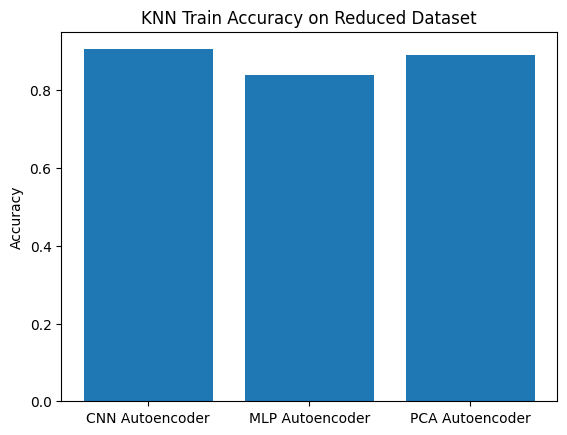

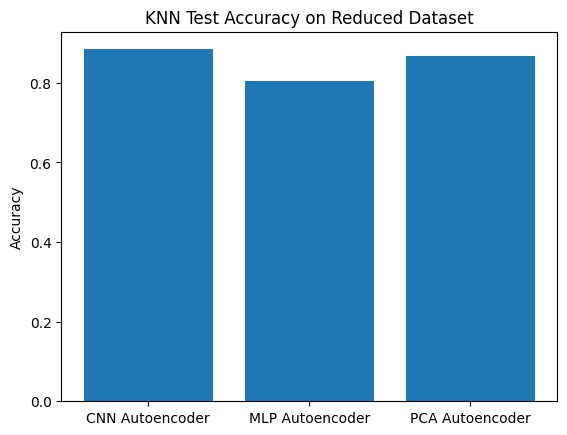

In [20]:
labels = ['CNN Autoencoder', 'MLP Autoencoder', 'PCA Autoencoder']
train_accuracies = [cnn_train_accuracy, mlp_train_accuracy, pca_train_accuracy]
test_accuracies = [cnn_test_accuracy, mlp_test_accuracy, pca_test_accuracy]

plt.bar(labels, train_accuracies)
plt.ylabel('Accuracy')
plt.title('KNN Train Accuracy on Reduced Dataset')
plt.savefig('figures/knn_train_accuracies.png')
plt.show()

plt.bar(labels, test_accuracies)
plt.ylabel('Accuracy')
plt.title('KNN Test Accuracy on Reduced Dataset')
plt.savefig('figures/knn_test_accuracies.png')
plt.show()

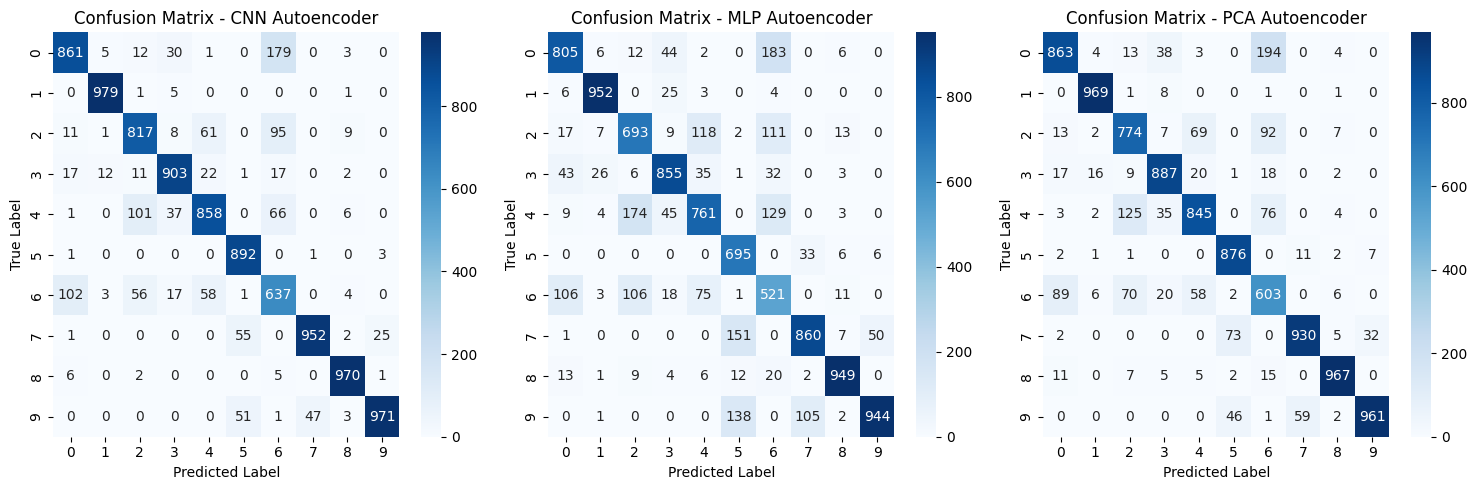

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cnn_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - CNN Autoencoder')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(mlp_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - MLP Autoencoder')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')


sns.heatmap(pca_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Confusion Matrix - PCA Autoencoder')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.savefig('figures/confusion_matrices_on_reduced_data.png')
plt.show()

By looking at the above confusion matrices we can see that all autoencoder model performs better on class-1,7,8,9 as these classes have higher number of correct predictions